# Construir um modelo de classificação: Deliciosas Cozinhas Asiáticas e Indianas


## Classificadores de culinária 1

Nesta lição, vamos explorar uma variedade de classificadores para *prever uma culinária nacional específica com base em um grupo de ingredientes.* Enquanto fazemos isso, aprenderemos mais sobre algumas das formas como os algoritmos podem ser utilizados em tarefas de classificação.

### [**Questionário pré-aula**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Preparação**

Esta lição é uma continuação da nossa [lição anterior](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb), onde:

-   Fizemos uma introdução leve às classificações usando um conjunto de dados sobre todas as brilhantes culinárias da Ásia e da Índia 😋.

-   Explorámos alguns [verbos do dplyr](https://dplyr.tidyverse.org/) para preparar e limpar os nossos dados.

-   Criámos visualizações bonitas usando ggplot2.

-   Demonstrámos como lidar com dados desequilibrados ao pré-processá-los usando [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Mostrámos como `prep` e `bake` a nossa receita para confirmar que funcionará como esperado.

#### **Pré-requisitos**

Para esta lição, precisaremos dos seguintes pacotes para limpar, preparar e visualizar os nossos dados:

-   `tidyverse`: O [tidyverse](https://www.tidyverse.org/) é uma [coleção de pacotes R](https://www.tidyverse.org/packages) projetada para tornar a ciência de dados mais rápida, fácil e divertida!

-   `tidymodels`: O [tidymodels](https://www.tidymodels.org/) é uma [framework de pacotes](https://www.tidymodels.org/packages/) para modelagem e aprendizagem automática.

-   `themis`: O [pacote themis](https://themis.tidymodels.org/) fornece passos adicionais de receitas para lidar com dados desequilibrados.

-   `nnet`: O [pacote nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) fornece funções para estimar redes neurais feed-forward com uma única camada oculta e para modelos de regressão logística multinomial.

Pode instalá-los da seguinte forma:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Alternativamente, o script abaixo verifica se tem os pacotes necessários para completar este módulo e instala-os caso estejam em falta.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Dividir os dados em conjuntos de treino e teste.

Vamos começar por selecionar alguns passos da nossa lição anterior.

### Eliminar os ingredientes mais comuns que geram confusão entre diferentes cozinhas, utilizando `dplyr::select()`.

Toda a gente adora arroz, alho e gengibre!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Perfeito! Agora, é hora de dividir os dados de forma que 70% dos dados sejam destinados ao treino e 30% aos testes. Também aplicaremos uma técnica de `estratificação` ao dividir os dados para `manter a proporção de cada tipo de cozinha` nos conjuntos de treino e validação.

[rsample](https://rsample.tidymodels.org/), um pacote do Tidymodels, fornece infraestrutura para divisão e reamostragem eficiente de dados:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Lidar com dados desequilibrados

Como deve ter reparado no conjunto de dados original, assim como no nosso conjunto de treino, há uma distribuição bastante desigual no número de tipos de cozinha. As cozinhas coreanas são *quase* 3 vezes mais numerosas do que as cozinhas tailandesas. Dados desequilibrados frequentemente têm efeitos negativos no desempenho do modelo. Muitos modelos funcionam melhor quando o número de observações é igual e, por isso, tendem a ter dificuldades com dados desequilibrados.

Existem principalmente duas formas de lidar com conjuntos de dados desequilibrados:

-   adicionar observações à classe minoritária: `Over-sampling`, por exemplo, utilizando um algoritmo SMOTE que gera sinteticamente novos exemplos da classe minoritária com base nos vizinhos mais próximos desses casos.

-   remover observações da classe majoritária: `Under-sampling`

Na nossa lição anterior, demonstrámos como lidar com conjuntos de dados desequilibrados utilizando uma `recipe`. Uma recipe pode ser vista como um plano que descreve os passos que devem ser aplicados a um conjunto de dados para prepará-lo para análise. No nosso caso, queremos ter uma distribuição igual no número de tipos de cozinha no nosso `conjunto de treino`. Vamos começar!


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Pode, claro, confirmar (usando prep+bake) que a receita funcionará como esperado - todas as etiquetas de cozinha têm `559` observações.

Como vamos usar esta receita como um pré-processador para modelagem, um `workflow()` fará todo o trabalho de preparação e execução para nós, então não será necessário estimar manualmente a receita.

Agora estamos prontos para treinar um modelo 👩‍💻👨‍💻!

## 3. Escolher o seu classificador

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Arte por @allison_horst</figcaption>


Agora temos de decidir qual algoritmo usar para o trabalho 🤔.

No Tidymodels, o [`parsnip package`](https://parsnip.tidymodels.org/index.html) fornece uma interface consistente para trabalhar com modelos em diferentes motores (pacotes). Consulte a documentação do parsnip para explorar [tipos de modelos e motores](https://www.tidymodels.org/find/parsnip/#models) e os seus correspondentes [argumentos de modelo](https://www.tidymodels.org/find/parsnip/#model-args). A variedade pode ser bastante confusa à primeira vista. Por exemplo, os seguintes métodos incluem técnicas de classificação:

-   Modelos de Classificação Baseados em Regras C5.0

-   Modelos de Discriminação Flexível

-   Modelos de Discriminação Linear

-   Modelos de Discriminação Regularizada

-   Modelos de Regressão Logística

-   Modelos de Regressão Multinomial

-   Modelos de Bayes Ingénuo

-   Máquinas de Vetores de Suporte

-   Vizinhos Mais Próximos

-   Árvores de Decisão

-   Métodos de Ensemble

-   Redes Neuronais

E a lista continua!

### **Qual classificador escolher?**

Então, qual classificador deve escolher? Muitas vezes, testar vários e procurar um bom resultado é uma forma de experimentar.

> O AutoML resolve este problema de forma prática ao realizar estas comparações na nuvem, permitindo-lhe escolher o melhor algoritmo para os seus dados. Experimente [aqui](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Além disso, a escolha do classificador depende do nosso problema. Por exemplo, quando o resultado pode ser categorizado em `mais de duas classes`, como no nosso caso, deve usar um `algoritmo de classificação multiclasses` em vez de `classificação binária.`

### **Uma abordagem melhor**

Uma abordagem melhor do que adivinhar aleatoriamente, no entanto, é seguir as ideias deste [Guia de Referência de ML](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott) disponível para download. Aqui, descobrimos que, para o nosso problema de multiclasses, temos algumas opções:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Uma secção do Guia de Referência de Algoritmos da Microsoft, detalhando opções de classificação multiclasses</figcaption>


### **Raciocínio**

Vamos analisar diferentes abordagens dadas as restrições que temos:

-   **Redes Neurais Profundas são demasiado pesadas**. Dado o nosso conjunto de dados limpo, mas minimalista, e o facto de estarmos a executar o treino localmente através de notebooks, redes neurais profundas são demasiado pesadas para esta tarefa.

-   **Sem classificador de duas classes**. Não utilizamos um classificador de duas classes, o que elimina a abordagem um-contra-todos.

-   **Árvore de decisão ou regressão logística podem funcionar**. Uma árvore de decisão pode funcionar, ou regressão multinomial/regressão logística multiclasses para dados multiclasses.

-   **Árvores de decisão multiclasses impulsionadas resolvem outro problema**. A árvore de decisão multiclasses impulsionada é mais adequada para tarefas não paramétricas, por exemplo, tarefas destinadas a construir rankings, por isso não é útil para nós.

Além disso, normalmente antes de embarcar em modelos de aprendizagem automática mais complexos, como métodos de ensemble, é uma boa ideia construir o modelo mais simples possível para ter uma ideia do que está a acontecer. Assim, para esta lição, começaremos com um modelo de `regressão multinomial`.

> A regressão logística é uma técnica utilizada quando a variável de resultado é categórica (ou nominal). Na regressão logística binária, o número de variáveis de resultado é dois, enquanto na regressão logística multinomial o número de variáveis de resultado é superior a dois. Consulte [Advanced Regression Methods](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) para leitura adicional.

## 4. Treinar e avaliar um modelo de regressão logística multinomial.

No Tidymodels, `parsnip::multinom_reg()`, define um modelo que utiliza preditores lineares para prever dados multiclasses usando a distribuição multinomial. Consulte `?multinom_reg()` para conhecer as diferentes formas/motores que pode usar para ajustar este modelo.

Neste exemplo, ajustaremos um modelo de regressão multinomial através do motor padrão [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf).

> Escolhi um valor para `penalty` de forma um pouco aleatória. Existem formas melhores de escolher este valor, nomeadamente utilizando `resampling` e ajustando o modelo, algo que discutiremos mais tarde.
>
> Consulte [Tidymodels: Get Started](https://www.tidymodels.org/start/tuning/) caso queira aprender mais sobre como ajustar os hiperparâmetros do modelo.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Bom trabalho 🥳! Agora que temos uma receita e uma especificação de modelo, precisamos encontrar uma forma de agrupá-los num objeto que primeiro pré-processará os dados, depois ajustará o modelo nos dados pré-processados e também permitirá atividades de pós-processamento, caso necessário. No Tidymodels, este objeto prático é chamado de [`workflow`](https://workflows.tidymodels.org/) e organiza convenientemente os seus componentes de modelação! Isto é o que chamaríamos de *pipelines* em *Python*.

Então, vamos agrupar tudo num workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Workflows 👌👌! Um **`workflow()`** pode ser ajustado de forma muito semelhante a um modelo. Então, é hora de treinar um modelo!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Os resultados mostram os coeficientes que o modelo aprendeu durante o treino.

### Avaliar o Modelo Treinado

É hora de verificar como o modelo se saiu 📏 avaliando-o num conjunto de teste! Vamos começar por fazer previsões no conjunto de teste.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Bom trabalho! No Tidymodels, avaliar o desempenho do modelo pode ser feito usando [yardstick](https://yardstick.tidymodels.org/) - um pacote utilizado para medir a eficácia dos modelos através de métricas de desempenho. Como fizemos na nossa aula de regressão logística, vamos começar por calcular uma matriz de confusão.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Ao lidar com várias classes, é geralmente mais intuitivo visualizar isto como um mapa de calor, assim:


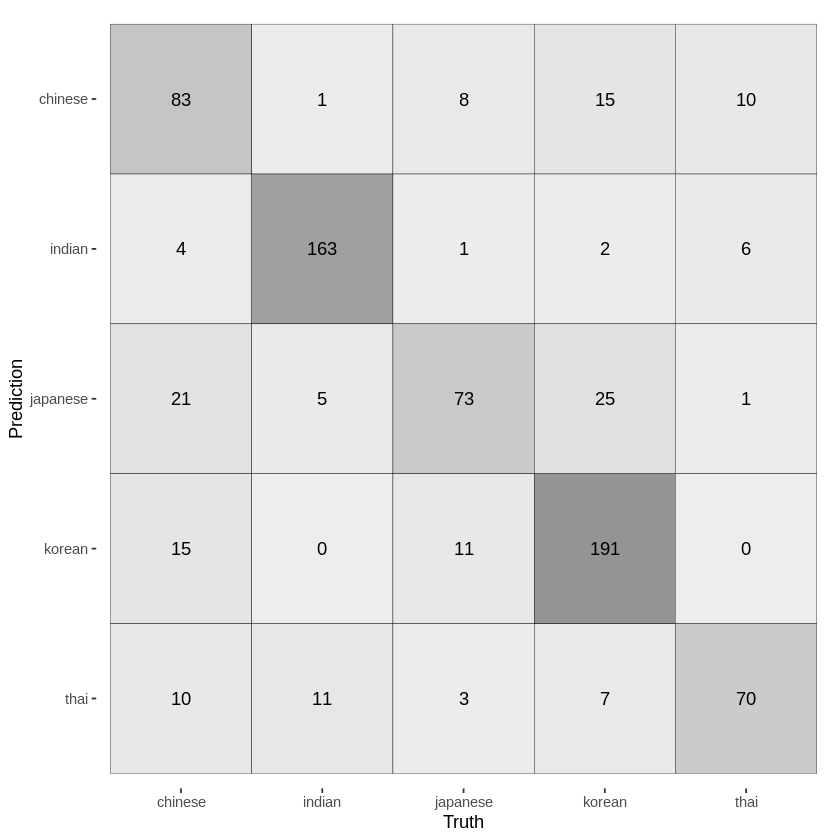

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Os quadrados mais escuros no gráfico da matriz de confusão indicam um número elevado de casos, e espera-se que consiga ver uma linha diagonal de quadrados mais escuros, indicando os casos em que o rótulo previsto e o rótulo real são iguais.

Vamos agora calcular as estatísticas resumidas para a matriz de confusão.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Se nos concentrarmos em algumas métricas como precisão, sensibilidade, ppv, não estamos mal para começar 🥳!

## 4. Aprofundando

Vamos fazer uma pergunta subtil: Que critérios são usados para decidir por um determinado tipo de cozinha como o resultado previsto?

Bem, os algoritmos de aprendizagem automática estatística, como a regressão logística, baseiam-se em `probabilidade`; portanto, o que é realmente previsto por um classificador é uma distribuição de probabilidade sobre um conjunto de resultados possíveis. A classe com a maior probabilidade é então escolhida como o resultado mais provável para as observações dadas.

Vamos ver isto em ação, fazendo tanto previsões de classes rígidas como probabilidades.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

✅ Consegues explicar porque é que o modelo tem tanta certeza de que a primeira observação é tailandesa?

## **🚀Desafio**

Nesta lição, utilizaste os teus dados limpos para construir um modelo de machine learning capaz de prever uma cozinha nacional com base numa série de ingredientes. Dedica algum tempo a explorar as [muitas opções](https://www.tidymodels.org/find/parsnip/#models) que o Tidymodels oferece para classificar dados e [outras formas](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) de ajustar regressões multinomiais.

#### AGRADECIMENTOS A:

[`Allison Horst`](https://twitter.com/allison_horst/) por criar as ilustrações incríveis que tornam o R mais acolhedor e envolvente. Encontra mais ilustrações na sua [galeria](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) e [Jen Looper](https://www.twitter.com/jenlooper) por criarem a versão original deste módulo em Python ♥️

<br>
Teria incluído algumas piadas, mas não percebo trocadilhos sobre comida 😅.

<br>

Boas aprendizagens,

[Eric](https://twitter.com/ericntay), Embaixador Estudante Gold da Microsoft Learn.



---

**Aviso Legal**:  
Este documento foi traduzido utilizando o serviço de tradução por IA [Co-op Translator](https://github.com/Azure/co-op-translator). Embora nos esforcemos para garantir a precisão, esteja ciente de que traduções automáticas podem conter erros ou imprecisões. O documento original no seu idioma nativo deve ser considerado a fonte oficial. Para informações críticas, recomenda-se uma tradução profissional realizada por humanos. Não nos responsabilizamos por quaisquer mal-entendidos ou interpretações incorretas resultantes do uso desta tradução.
